## Imports

In [1]:
#Library imports
import re
import os
import shutil
import time
import math
import fnmatch
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

from IPython.display import Image, display
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2


#User Created functions

from cleaning_functions import *
from eda_functions import *
from modeling_functions import *
from setup_functions import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
#Without this block the Japanese font's won't display properly in Matplotlib.Set to your font directory.
extend_matplotlib_fonts("/usr/share/fonts/")

/home/anacuda/work/nyc-mhtn-ds-021720/japanese_text_classifiers/setup_functions.py:23: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [3]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

Since there are many classes, I've imported a json that contains useful information about the characters and stored it into a DataFrame.

In [5]:
hiragana_classes = pd.read_json("choubenkyo_kivy_app/app/draw_screen/characters/hiragana.json")

# By converting the recorded stroke count to a list of integers, it will be easier to iterate through the data and remove obvious mistakes from the start.
hiragana_classes["stroke_count"] = hiragana_classes["stroke_count"].map(lambda x: [int(item[0]) for item in re.finditer("\d+", x)])

# It will be useful to have seperate dataframes to account for dropped classes whether they are the obsolete kana or the compound characters.
current_hiragana_classes = hiragana_classes[(hiragana_classes["char_id"]!= "wi") & (hiragana_classes["char_id"]!= "we")].reset_index(drop=True)
reduced_hiragana_classes = current_hiragana_classes.iloc[0:46]
compound_hiragana_classes = current_hiragana_classes.iloc[46:]

## EDA and Data Conversion for the App Generated Observations

The data generated through the app is stored in the form of x and y coordinates from user interaction with the canvas in the order that they were pressed. The x and y coordinates are stored with in an array but each stroke (created each time the user lifts their finger from the screen) is stored within a larger dictionary seperated by integer keys that reference the order of creation. The following example is a recording of a capture for the hiragana character ぞ (zo) which was not included in the kuzushiji dataset, but it's base form そ (so) was.

The values can range from a -1 to 1 across an input area that is consistently a perfect square. Storing it this way is both lightweight and preserves more information regarding stroke order and direction than a bitmap would provide.

In [60]:
example = load_pickle("data/choubenkyo_data/example.pickle")
example

{1: array([[-0.63829786,  0.54441524],
        [-0.59969783,  0.54115534],
        [-0.52203854,  0.53634429],
        [-0.28445774,  0.52590561],
        [-0.18277665,  0.52704024],
        [-0.11830277,  0.53096032],
        [-0.07959127,  0.53289294],
        [-0.05653203,  0.534132  ],
        [-0.06179174,  0.52601171],
        [-0.19258281,  0.38362145],
        [-0.28640158,  0.2893858 ],
        [-0.38861911,  0.19933558],
        [-0.46727445,  0.13545966],
        [-0.51671651,  0.09681916],
        [-0.54672268,  0.07867789],
        [-0.54990232,  0.07755327],
        [-0.50747295,  0.10083437],
        [-0.23254772,  0.1803453 ],
        [ 0.09554889,  0.21719646],
        [ 0.23005591,  0.23266578],
        [ 0.29517465,  0.24193215],
        [ 0.35456353,  0.25031304],
        [ 0.36077711,  0.25031304],
        [ 0.36175251,  0.2513938 ],
        [ 0.35126064,  0.25526381],
        [ 0.31375249,  0.25627375],
        [ 0.1178258 ,  0.17634535],
        [ 0.01229286,  0.

The first goal is to convert all the raw coordinate data collected from the phone app into 28 x 28 greyscale images to match the other datasets. The Pillow library has a function that can render these points to a bitmap image. Since the app creating this data was built in Kivy, the coordinate space is reversed along the y axis, but rectifying that is an easy fix. I've created several functions that ensure that the images are rendered to be centered/filled to the image space.

In [56]:
# This is the master function which references some helper functions in the cleaning_functions python file.
def render_coordinates_file_to_img(coord_list, resolution=(28, 28), stroke_width=2):
    """takes a list of strokes and uses Pillow's image draw function after scaling them to fill the desired resolution."""
    
    #Scales linedata to have a centered maximum fit within the desired resoltion.
    scaled = scale_points_for_pixels(coord_list, resolution, stroke_width)
    
    img = Image.new('L', resolution, color=0)
    draw = ImageDraw.Draw(img)
    for coords in scaled:
        line_from_array(draw, coords, width=stroke_width)
    return img

It's evident that when viewed at this size, you can clearly see a polygonal structure that represents the frequency of the recorded points. Both movement factors and temporal factors influence the amount of coordinates recorded in the app, so faster drawn strokes may have some gaps in the data.

At the small resolution being used for training, this doesn't make much of a difference but varying amounts of point data prevent observations from being conveniently aggregated into arrays and will pose a problem in terms of compatibility with an LSTM model.

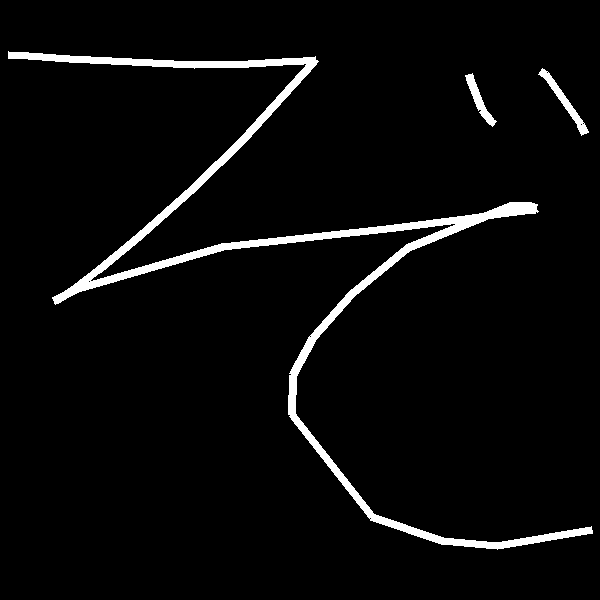

In [64]:
example_fixed_orientation = [[1, -1] * value for key, value in sorted(example.items())]
render_coordinates_file_to_img(example_fixed_orientation, (600, 600), 8)

Instead I chose to enhance both the lstm and the bitmap files by standardizing it to a consistent number of points along a b-spline (done using the [NURBS-Python library](https://nurbs-python.readthedocs.io)). Having a consistent shape for all of the parameters is essential for the lstm and if I were to accomplish this through downsampling the points, it would outright ruin the data in many scenarios.

In [70]:
# Located in the cleaning functions python file, this function fixes the orientation and converts each raw points dictionary
# into a list of their interpolations along a b-spline.
example_b_spline = parse_to_points_list(example)

#The shaoe is consistent and the coordinates should be sufficient for each observation.
for bspline_array in example_b_spline:
    print(bspline_array.shape)
    
#Looking at the first few datapoints in this notably long and complicated stroke, you can see that there are now more datapoints.
example_b_spline[0][0:10,:]

(120, 2)
(120, 2)
(120, 2)


array([[-0.63829786, -0.54441524],
       [-0.60672055, -0.54194369],
       [-0.57271578, -0.53968049],
       [-0.53395568, -0.53746331],
       [-0.48813958, -0.53513149],
       [-0.43542595, -0.53267543],
       [-0.38035868, -0.53035499],
       [-0.32793501, -0.52845787],
       [-0.28294698, -0.52725816],
       [-0.24661001, -0.5267928 ]])

How does this generated data hold up when visualized?

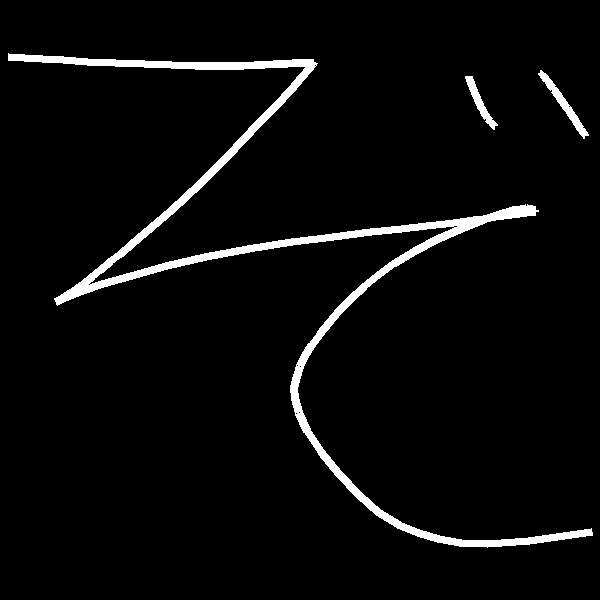

In [71]:
render_coordinates_file_to_img(example_b_spline, (600, 600), 8)

The B-spline made the intermediate transitions natural along a curve and while typically use of a b-spline would smooth out corner points in an obtrusive way, the real time capture of the app essentially captures more points during moments where the flow of writing is slowed down (ie. a sharp direction change). With a surplus of control points towards the corners, the smoothing is minimized in places where it wouldn't be desired.

## The Data Preprocessing Workflow

In order to minimize computation time, the following code simultaneously constructs the saved images for the CNN and the converted observations for the LSTM

In [7]:
# Stroring the common paths in variables
raw_path = "data/choubenkyo_data/raw"
rendered_path = "data/choubenkyo_data/rasterized"
rendered_split_paths = {"train": os.path.join(rendered_path, "train"),
                        "val": os.path.join(rendered_path, "val"),
                        "test": os.path.join(rendered_path, "test")}

In [8]:
# Reproducible results
np.random.seed(SEED)

# This will control the last dimension of the LSTM layer.
max_features=80

#There are several variations of classes to test on so storing the variable here will make it easier to switch between them.
class_list = reduced_hiragana_classes

#Creating the inital train, val, test directories. Function located in "cleaning_functions."
create_classification_dirs(rendered_split_paths.values(), class_list["char_id"])

# This is the list which will become the lstm input and labels
choubenkyo_data = []
choubenkyo_raw_labels = []

#This list will reference the directory of origin, and the files that are generated/renamed through the train, test, split
#to external image file functions.
pathmap = []

for source in os.listdir(raw_path):
    old_dir = os.path.join(raw_path, source)
    contents = os.listdir(old_dir)
    for label in class_list["char_id"]:
        matches = fnmatch.filter(contents, f"{label}*")
        np.random.shuffle(matches)
        match_splits = (image_path_list_train_test_split(matches, .7, .1))
        new_file_counters = [len(os.listdir(os.path.join(split_dir, label))) for split_dir in rendered_split_paths.values()]
        for i,(key, value) in enumerate(rendered_split_paths.items()):
            new_dir = os.path.join(value, label)
            for match in match_splits[i]:
                match_raw_path = os.path.join(old_dir, match)
                raw_strokes = load_pickle(match_raw_path)
                smoothed_strokes = parse_to_points_list(raw_strokes)
                if len(raw_strokes) not in hiragana_classes[hiragana_classes["char_id"]==label]["stroke_count"].reset_index(drop=True)[0]:
                    pathmap.append([match_raw_path, np.nan])
                    continue
                new_path = os.path.join(new_dir, f"{label}{key}{new_file_counters[i]:05}.png")
                
                #Exports images for the CNN.
                img = render_coordinates_file_to_img(smoothed_strokes, stroke_width=1)
                img = ImageOps.expand(img, 2)
                img.save(new_path)
                
                #Saves observations for the lstm
                choubenkyo_data.append(strokes_to_array(smoothed_strokes, max_features=max_features))
                choubenkyo_raw_labels.append(label)
                
                #Saves information to the document that preserves the link to the source images.
                pathmap.append([match_raw_path, new_path])
                
                #Tracks changes to image iterator so some searches for existing directories can be avoided.
                new_file_counters[i] += 1

pathmap = pd.DataFrame(pathmap, columns=["orig_file", "new_file"])
choubenkyo_data = np.vstack(choubenkyo_data)
choubenkyo_raw_labels = pd.Series(choubenkyo_raw_labels)

### LSTM Specific Adjustments

The labels are taken care of automatically when Keras's image generator reads from a directory, but the LSTM data will need their labels adjusted to support one-hot encoding.

In [ ]:
#Creating a dictionary that will be used to map the character id to an index.
class_list_label_dict = {key:value for key, value in class_list.reset_index()[["char_id","index"]].to_numpy()}

#Mapping to the index so that each label is an integer.
choubenkyo_labels = choubenkyo_raw_labels.map(class_list_label_dict)

It also requires it's own train. test, split. And the following function does that along with standardizing the data.

In [72]:
def preprocess_lstm_pipeline(array, labels, test_size=None, val_size=None, random_seed=None):

    nobs, sequence_length, nfeatures = array.shape

    #App provides possible values range from -1 to 1. This will standardize the data for machine learning, while
    #also preserving information present in the relative size of a drawing.
    scaled_array = (array.copy() + 1)/2
    labels = labels.copy()
    
    array1d = scaled_array.reshape([nobs, -1])
    
    if test_size and val_size:
        print("Performing a train, test, validation split.")
        X_int, X_test, y_int, y_test = train_test_split(array1d, labels, test_size=test_size, random_state=random_seed)
        X_train, X_val, y_train, y_val = train_test_split(X_int, y_int, test_size=val_size, random_state=random_seed)
        return X_train.reshape([-1, sequence_length, nfeatures]), X_val.reshape([-1, sequence_length, nfeatures]), X_test.reshape([-1, sequence_length, nfeatures]), to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)
    if test_size or val_size:
        print("Performing a train, test split.")
        test_size = max([test_size, val_size])
        X_train, X_test, y_train, y_test = train_test_split(array1d, labels, test_size=test_size, random_state=random_seed)
        return X_train.reshape([-1, sequence_length, nfeatures]), X_test.reshape([-1, sequence_length, nfeatures]), to_categorical(y_train), to_categorical(y_test)
    else:
        print("Skipping train, test, split")
        return scaled_array, to_categorical(labels)
    
        #One hot encodes the labels in order to be fit to the lstm.
    labels = to_categorical(labels.copy())

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_lstm_pipeline(choubenkyo_data, choubenkyo_labels, .2, .1, random_seed=SEED)

Instead of running an upsample or downsample function, in this instance I handled any possible class imbalances by assigning class weights.

In [ ]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            classes = np.unique(np.argmax(y_train, axis = 1)), 
            y = np.argmax(y_train, axis = 1))

### CNN Specific Adjustments

Since the splits are already in place in the filesystem, the CNN just requires the instantiation of it's generators. The train parameters once gain are a light degree of transformations without reflecting the character.

In [9]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=4,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
test_generator = ImageDataGenerator(rescale=1./255)

In [21]:
X_train_generator = train_generator.flow_from_directory(rendered_split_paths["train"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_val_generator = test_generator.flow_from_directory(rendered_split_paths["val"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_test_generator = test_generator.flow_from_directory(rendered_split_paths["test"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)

# I've also created a quick version on the larger training set with no transformations to be tested against the kujishiji model
# wtugut any training.
untransformed_train = test_generator.flow_from_directory(rendered_split_paths["train"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)

Found 1055 images belonging to 46 classes.
Found 305 images belonging to 46 classes.
Found 218 images belonging to 46 classes.
Found 1055 images belonging to 46 classes.


## Modeling

### The CNN

This is a CNN without transfer learning, but maintains the same node structure as the models in the Kuzushiki dataset.

In [11]:
layers = [Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32 ,32,  1)),
          Conv2D(32, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(40, "relu"),
          Dense(46, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelc1 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         7

In [ ]:
backups = ModelCheckpoint("model_backups/choubenkyo/modelc1-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

resultsc1 = modelc1.fit(X_train_generator, epochs=200, steps_per_epoch=32, validation_data=X_val_generator, validation_steps=9, callbacks=[backups, stopping])

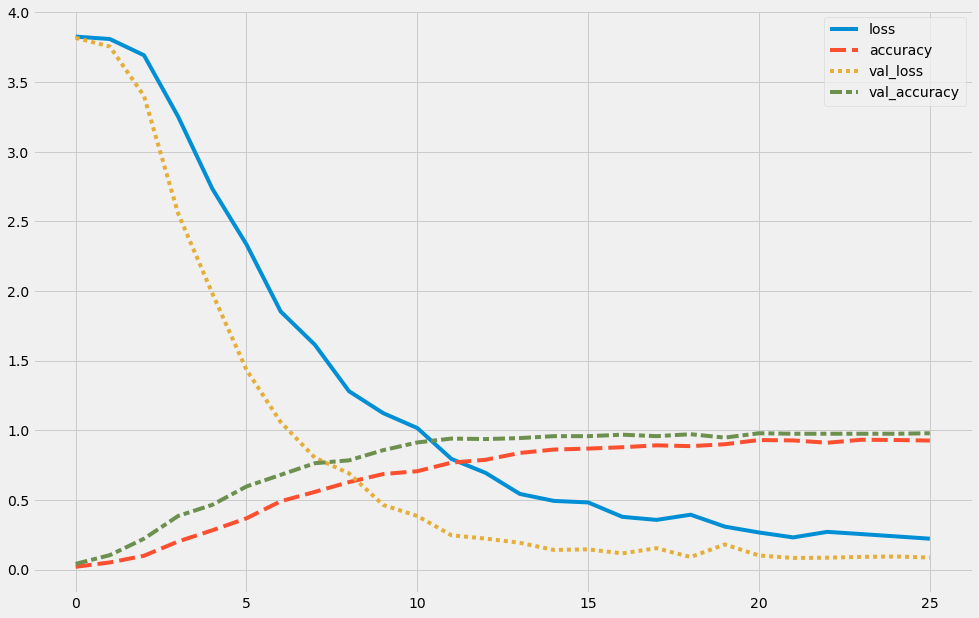

,loss,accuracy,val_loss,val_accuracy
21,0.231438,0.927664,0.084016,0.975694
22,0.271324,0.911046,0.085681,0.975694
23,0.255301,0.932551,0.091672,0.975694
24,0.238918,0.930596,0.094594,0.975694
25,0.222153,0.926686,0.086479,0.979167


In [13]:
plot_keras_fit_history(resultsc1, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [14]:
%%time
test_batch = next(X_test_generator)
image_class_evaluation(modelc1, test_batch[0], test_batch[1])

Accuracy: 0.96875
Balanced Accuracy: 0.9821428571428571
CPU times: user 67.6 ms, sys: 15.3 ms, total: 82.9 ms
Wall time: 80.9 ms


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.96875, 0.9821428571428571)

### CNN With Transfer Learning

In [15]:
modelkuzushiji = models.load_model('model_backups/kuzushiji/model6-26')

#### Examining the performance of the kuzushiji model with no additional training

In [22]:
%%time
test_batch = next(untransformed_train)
image_class_evaluation(modelkuzushiji, test_batch[0], test_batch[1])

Accuracy: 0.03125
Balanced Accuracy: 0.045454545454545456
CPU times: user 73.5 ms, sys: 16.3 ms, total: 89.8 ms
Wall time: 88.8 ms


(0.03125, 0.045454545454545456)

#### Using the Kuzushiji trained model but freezing only two sets of convolutions

In [16]:
layers = modelkuzushiji.layers[:-2] + [Dense(40, "relu"), Dense(46, activation='softmax')]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00005), "metrics":['accuracy']}
modelc2 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

In [17]:
for layer in modelc2.layers[0:6]:
    layer.trainable = False

In [ ]:
backups = ModelCheckpoint("model_backups/choubenkyo/modelc2-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

resultsc2 = modelc2.fit(X_train_generator, epochs=200, steps_per_epoch=32, validation_data=X_val_generator, validation_steps=9, callbacks=[backups, stopping])

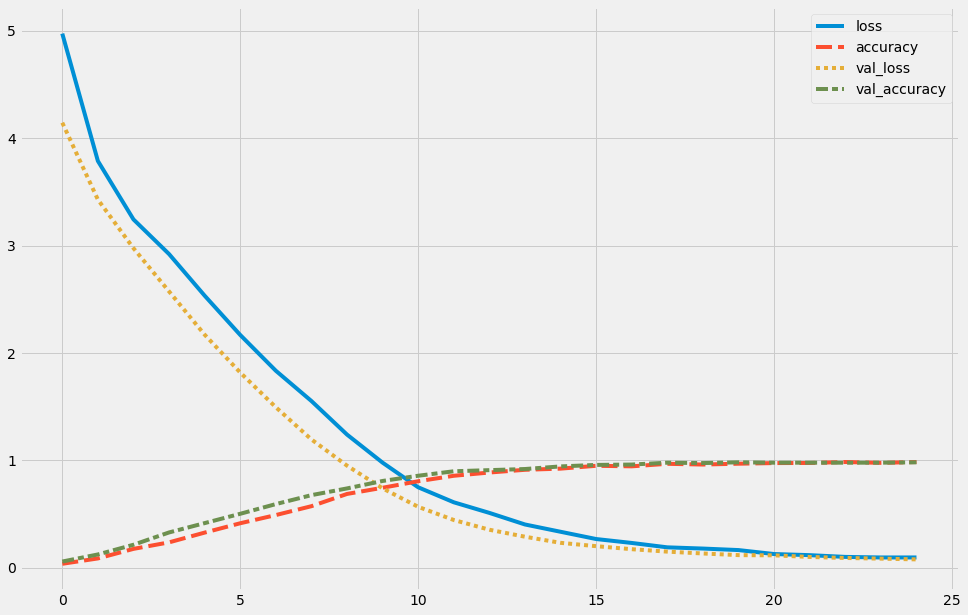

,loss,accuracy,val_loss,val_accuracy
20,0.128854,0.975562,0.116857,0.979167
21,0.118504,0.976540,0.101695,0.979167
22,0.102179,0.985337,0.092427,0.979167
23,0.096992,0.977517,0.086125,0.979167
24,0.097105,0.985337,0.079093,0.982639


In [19]:
plot_keras_fit_history(resultsc2, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [20]:
%%time
test_batch = next(X_test_generator)
image_class_evaluation(modelc2, test_batch[0], test_batch[1])

Accuracy: 0.9375
Balanced Accuracy: 0.9637681159420289
CPU times: user 72 ms, sys: 12.2 ms, total: 84.1 ms
Wall time: 81.3 ms


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.9375, 0.9637681159420289)

#### Using the Kuzushiji Kanji trained model but freezing only the first set of convolutions

In [23]:
modelkanji = models.load_model('model_backups/kanji/modelk1-33')

In [24]:
layers = modelkanji.layers[:-2] + [Dense(40, "relu"), Dense(46, activation='softmax')]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00005), "metrics":['accuracy']}
modelc3 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

In [26]:
for layer in modelc3.layers[0:3]:
    layer.trainable = False

In [ ]:
backups = ModelCheckpoint("model_backups/choubenkyo/modelc3-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

resultsc3 = modelc3.fit(X_train_generator, epochs=200, steps_per_epoch=32, validation_data=X_val_generator, validation_steps=9, callbacks=[backups, stopping])

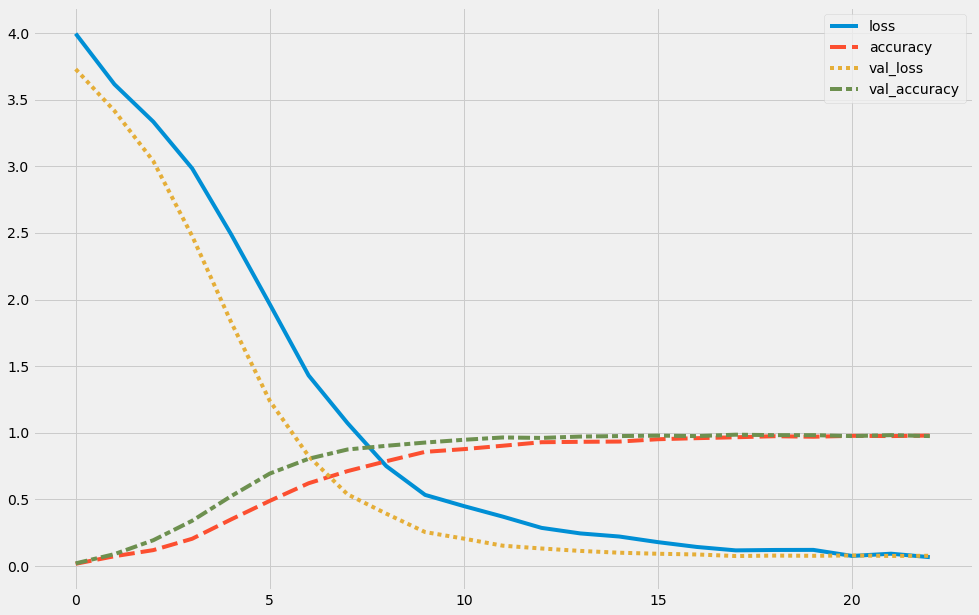

,loss,accuracy,val_loss,val_accuracy
18,0.121260,0.974585,0.079039,0.982639
19,0.121872,0.970675,0.077480,0.982639
20,0.076472,0.977517,0.080121,0.975694
21,0.093278,0.975562,0.076370,0.982639
22,0.067241,0.979472,0.077799,0.975694


In [28]:
plot_keras_fit_history(resultsc3, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [29]:
%%time
test_batch = next(X_test_generator)
image_class_evaluation(modelc3, test_batch[0], test_batch[1])

Accuracy: 0.96875
Balanced Accuracy: 0.9642857142857143
CPU times: user 69.3 ms, sys: 11.2 ms, total: 80.5 ms
Wall time: 78.3 ms


(0.96875, 0.9642857142857143)

### The LSTM

In [52]:
layers = [LSTM(200, input_shape=(120,max_features)),
          Dropout(0.1),
          Dense(40, activation='relu'),
          Dense(46, activation='softmax'),
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00004), "metrics":['accuracy']}
modelc4 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200)               224800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 40)                8040      
_________________________________________________________________
dense_17 (Dense)             (None, 46)                1886      
Total params: 234,726
Trainable params: 234,726
Non-trainable params: 0
_________________________________________________________________


In [ ]:
backups = ModelCheckpoint("model_backups/kanji/modelc4-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=8, restore_best_weights=True)

resultsc4 = modelc4.fit(X_train, y_train, epochs=200, batch_size=10, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[backups, stopping])

Graphing the results of the LSTM over the epochs reveals much more volitility. I would like to add on more observations before refining further.

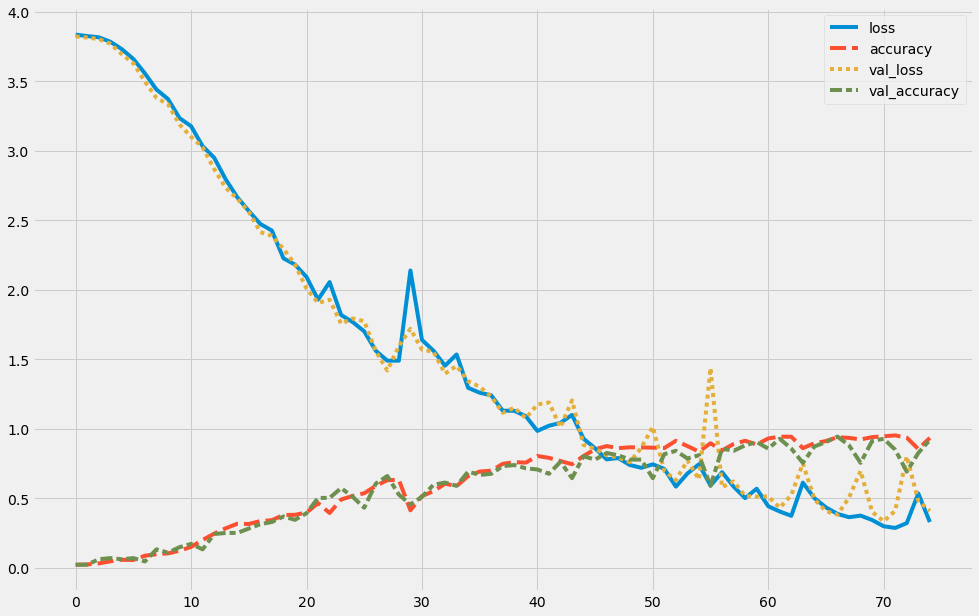

,loss,accuracy,val_loss,val_accuracy
70,0.300004,0.947137,0.335463,0.929134
71,0.287917,0.953304,0.411589,0.850394
72,0.322568,0.937445,0.802823,0.692913
73,0.536248,0.855507,0.482249,0.826772
74,0.330216,0.935683,0.410700,0.921260


In [74]:
plot_keras_fit_history(resultsc4, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [54]:
%%time
image_class_evaluation(modelc4, X_test, y_test)

Accuracy: 0.9240506329113924
Balanced Accuracy: 0.9238691260430388
CPU times: user 263 ms, sys: 4.63 ms, total: 268 ms
Wall time: 228 ms


(0.9240506329113924, 0.9238691260430388)

## Results

The scarcity of observations shows. There are some good preliminary signs across all the models, but need a bigger and more diverse set of observations to move forward.